# Mask land

Download data from e.g.: https://www.naturalearthdata.com/http//www.naturalearthdata.com/download/110m/physical/ne_110m_land.zip

unzip it in data_test/

## Reading data (CMIP-PPE)
You have to use the env:ml-notebook to run this example. 

In [1]:
import xarray as xr
import numpy as np
import pandas as pd
from pathlib import Path
xr.set_options(display_style='html')
import intake
import cftime
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import datetime
import seaborn as sns

### Open the overview over the parameters in the CAM6 CESM PPE

In [2]:

cat_url = '/mnt/craas1-ns9989k-geo4992/data/catalogs/cesm-ppe.json'
col = intake.open_esm_datastore(cat_url)
col

cat = col.search(
    experiment=['present-day'], 
    variable = ['SWCF'], 
    frequency='monthly',
    ensemble=1.0,
)

cat.df


cat.df['variable'].unique()

dset_dict = cat.to_dataset_dict()#preprocess = get_ensemble_member,)

ds = dset_dict['present-day.monthly']



--> The keys in the returned dictionary of datasets are constructed as follows:
	'experiment.frequency'


### Change longitude to -180 to 180

In [3]:
def convert_ds_lon_to_180(ds):
    ds['lon'] = (ds['lon']+ 180) % 360 - 180
    ds =ds.sortby('lon')
    return ds

ds_360 = ds.copy()
ds = convert_ds_lon_to_180(ds)

## Open shapefile

In [4]:
import geopandas as gpd
import rioxarray
shp = gpd.read_file(
    "data_test/ne_110m_land/ne_110m_land.shp",
)

In [5]:
da_for_map = ds['SWCF']

In [6]:
da_for_map.load()

<xarray.DataArray 'SWCF' (ensemble: 1, time: 36, lat: 192, lon: 288)> Size: 8MB
array([[[[-5.5925636 , -5.593125  , -5.5931134 , ..., -5.5908446 ,
          -5.59109   , -5.5915    ],
         [-5.4282913 , -5.3280287 , -5.272494  , ..., -5.610616  ,
          -5.5108867 , -5.46146   ],
         [-5.8035173 , -5.795386  , -5.765447  , ..., -5.832269  ,
          -5.8782983 , -5.796419  ],
         ...,
         [ 0.        ,  0.        ,  0.        , ...,  0.        ,
           0.        ,  0.        ],
         [ 0.        ,  0.        ,  0.        , ...,  0.        ,
           0.        ,  0.        ],
         [ 0.        ,  0.        ,  0.        , ...,  0.        ,
           0.        ,  0.        ]],

        [[-3.2400467 , -3.240092  , -3.2400918 , ..., -3.2387588 ,
          -3.23888   , -3.2395105 ],
         [-3.5281255 , -3.5519495 , -3.5952904 , ..., -3.4331818 ,
          -3.4734552 , -3.505729  ],
         [-3.610597  , -3.631725  , -3.6228158 , ..., -3.6889176 ,
          -3.6661172 , -3.6243472 ],
...
         [ 0.        ,  0.        ,  0.        , ...,  0.        ,
           0.        ,  0.        ],
         [ 0.        ,  0.        ,  0.        , ...,  0.        ,
           0.        ,  0.        ],
         [ 0.        ,  0.        ,  0.        , ...,  0.        ,
           0.        ,  0.        ]],

        [[-3.752373  , -3.7523866 , -3.7523732 , ..., -3.7514317 ,
          -3.7514026 , -3.751728  ],
         [-5.572253  , -5.572002  , -5.607301  , ..., -5.5122476 ,
          -5.511901  , -5.5242176 ],
         [-6.3164225 , -6.292485  , -6.268404  , ..., -6.259397  ,
          -6.307243  , -6.3393993 ],
         ...,
         [ 0.        ,  0.        ,  0.        , ...,  0.        ,
           0.        ,  0.        ],
         [ 0.        ,  0.        ,  0.        , ...,  0.        ,
           0.        ,  0.        ],
         [ 0.        ,  0.        ,  0.        , ...,  0.        ,
           0.        ,  0.        ]]]], dtype=float32)
Coordinates:
  * lat       (lat) float64 2kB -90.0 -89.06 -88.12 -87.17 ... 88.12 89.06 90.0
  * lon       (lon) float64 2kB -180.0 -178.8 -177.5 ... 176.2 177.5 178.8
  * time      (time) object 288B 0001-01-16 12:00:00 ... 0003-12-16 12:00:00
  * ensemble  (ensemble) float64 8B 1.0
Attributes:
    Sampling_Sequence:  rad_lwsw
    units:              W/m2
    long_name:          Shortwave cloud forcing
    cell_methods:       time: mean

In [7]:
df_shape = gpd.read_file('data_test/ne_110m_land/ne_110m_land.shp')
da_for_map = da_for_map.rio.set_spatial_dims(x_dim="lon", y_dim="lat")  # , inplace=True)
da_for_map = da_for_map.rio.write_crs("epsg:4326",)

# df_shape = geopandas.read_file('Data/Ecoregions2017/Ecoregions2017.shp', crs="epsg:4326")

df_shape.head()

,featurecla,scalerank,min_zoom,geometry
0,Land,1,1.0,"POLYGON ((-59.57209 -80.04018, -59.86585 -80.5..."
1,Land,1,1.0,"POLYGON ((-159.20818 -79.49706, -161.12760 -79..."
2,Land,1,0.0,"POLYGON ((-45.15476 -78.04707, -43.92083 -78.4..."
3,Land,1,1.0,"POLYGON ((-121.21151 -73.50099, -119.91885 -73..."
4,Land,1,1.0,"POLYGON ((-125.55957 -73.48135, -124.03188 -73..."


In [8]:
from shapely.geometry import mapping


In [9]:
land = df_shape[df_shape['featurecla'] == 'Land']
clipped = da_for_map.rio.clip(land.geometry.apply(mapping), land.crs, drop=False, invert=True)


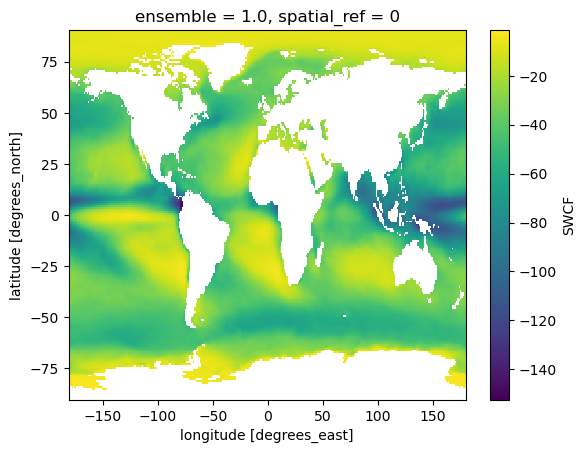

In [10]:
clipped.mean('time').plot()

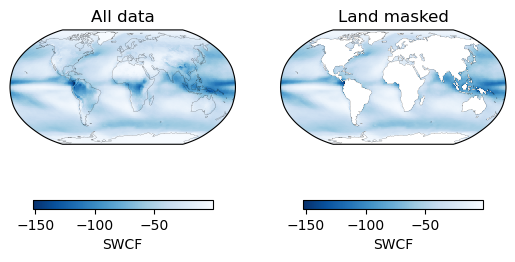

In [11]:
fig, axs = plt.subplots(1,2, subplot_kw={'projection':ccrs.Robinson()})
ds['SWCF'].mean('time').plot(transform=ccrs.PlateCarree(), 
                             cmap='Blues_r',
                             ax =axs[0],
                             cbar_kwargs={
                                 'orientation':'horizontal',
                                 'shrink':.8
                                 },
                             )
clipped.mean('time').plot(transform=ccrs.PlateCarree(),
                          cmap='Blues_r',
                          ax =axs[1],
                          cbar_kwargs={
                              'orientation':'horizontal',
                              'shrink':.8
                              },
                          )
axs[0].set_title('All data')
axs[1].set_title('Land masked')
for ax in axs:
    ax.coastlines(linewidth=.1)


## Alternative using a gridded land sea dataset: 


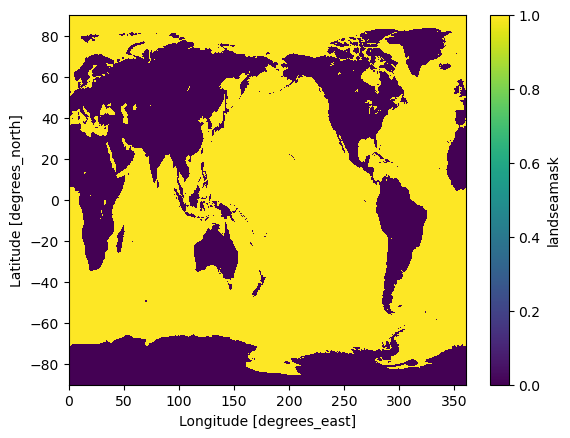

In [12]:
path='~/shared-craas1-ns9989k-geo4992/data/IMERG_land_sea_mask.nc'
ds_lndmsk = xr.open_dataset(path)
land_mask = xr.where(ds_lndmsk.landseamask > 75., 1., 0.)
land_mask.plot()

### Interpolate to grid

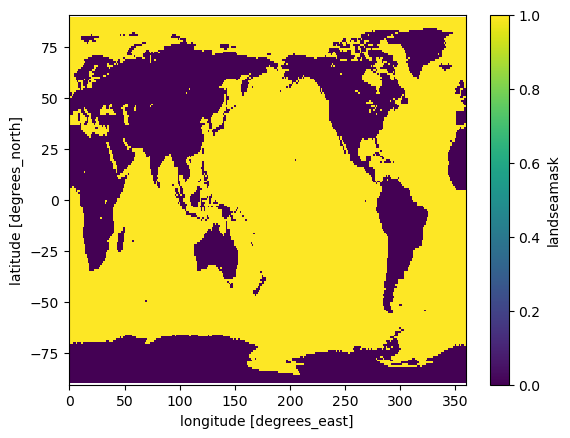

In [13]:
# (land_mask is a dataarray with the mask)
aligned_mask = land_mask.interp(lat=ds_360.lat, lon=ds_360.lon, method='nearest')
aligned_mask.plot()

In [14]:
import cartopy.crs as ccrs

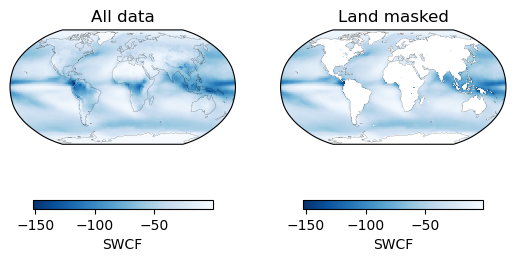

In [15]:
fig, axs = plt.subplots(1,2, subplot_kw={'projection':ccrs.Robinson()})
ds_360['SWCF'].mean('time').plot(transform=ccrs.PlateCarree(), 
                                 cmap='Blues_r',
                                 ax =axs[0],
                                 cbar_kwargs={
                                     #'label':'Wind Speed [m/s]',
                                     'orientation':'horizontal',
                                     'shrink':.8
                                     },
                                 )
ds_360['SWCF'].where(aligned_mask).mean('time').plot(transform=ccrs.PlateCarree(),
                                                     cmap='Blues_r',
                                                     ax =axs[1],
                                                     cbar_kwargs={
                                                         'orientation':'horizontal',
                                                         'shrink':.8
                                                         },
                                                     )
axs[0].set_title('All data')
axs[1].set_title('Land masked')
for ax in axs:
    ax.coastlines(linewidth=.1)
